In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        print(m.weight)
    elif type(m) == nn.BatchNorm1d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [6]:
def get_effnet(name="efficientnet-b0", pretrained=True, n_class=None):
    
    assert n_class != None, "Please specify the number of output classes `n_class`"
    
    if pretrained == True:
        print(f"Getting pretrained {name}")
        m = EfficientNet.from_pretrained(name)
    else:
        print(f"Getting random initialized {name}")
        m = EfficientNet.from_name(name)
    
    n_in = m._fc.in_features
    m._fc = nn.Sequential(
        nn.BatchNorm1d(n_in), 
        nn.Dropout(p=0.5), 
        nn.Linear(n_in, n_class))
    m._fc.apply(init_weights)
    return m

# Download and Untar Data

In [7]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')
train_idx, val_idx = train_test_split(train_df.index, test_size=0.2, random_state=42, stratify=train_df["class_name"])

In [ ]:
# learn.split(lambda m: (children(m)[-2],))

# B3, Squish Resize, 10 Epochs

In [8]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [9]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [10]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0299, -0.0417, -0.0137,  ..., -0.0197, -0.0463,  0.0436],
        [-0.0061, -0.0030,  0.0178,  ...,  0.0432,  0.0002,  0.0062],
        [ 0.0304,  0.0642,  0.0316,  ..., -0.0661,  0.0446,  0.0194],
        ...,
        [-0.0280, -0.0009, -0.0084,  ...,  0.0061, -0.0409, -0.0579],
        [-0.0291,  0.0014,  0.0423,  ..., -0.0057, -0.0387,  0.0390],
        [ 0.0446, -0.0331, -0.0032,  ...,  0.0154,  0.0014,  0.0089]],
       requires_grad=True)


In [11]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.265394,3.799470,0.161548,01:40
1,3.260346,4.782445,0.218673,01:37
2,3.310787,6.078644,0.195332,01:38
3,2.657969,3.786839,0.221744,01:41
4,1.861013,2.524836,0.386978,01:38
5,1.220321,1.538085,0.609951,01:36
6,0.728393,1.026640,0.732801,01:35
7,0.392983,0.652264,0.831081,01:37
8,0.193751,0.532811,0.860565,01:39
9,0.123847,0.497957,0.868550,01:36


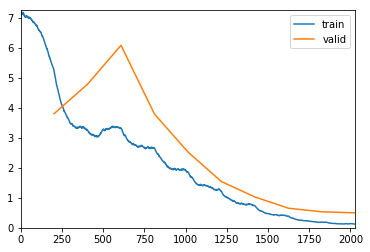

In [12]:
lr = 3e-3
wd = 1e-1
epochs = 10
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [13]:
learn.save("b3_squish_10epochs")

In [14]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.44424993, tensor(0.8776)]

# B3, Squish Resize, 20 Epochs

In [15]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [16]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [17]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0214, -0.0109,  0.0066,  ..., -0.0355,  0.0079, -0.0226],
        [ 0.0018, -0.0388, -0.0469,  ..., -0.0443, -0.0241, -0.0369],
        [-0.0452,  0.0010, -0.0592,  ...,  0.0320,  0.0004, -0.0130],
        ...,
        [-0.0064, -0.0607, -0.0888,  ..., -0.0149,  0.0142, -0.0095],
        [ 0.0143, -0.0107,  0.0167,  ..., -0.0031, -0.0422, -0.0236],
        [ 0.0321, -0.0235,  0.0469,  ...,  0.0285, -0.0235, -0.0349]],
       requires_grad=True)


In [18]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Dodge Journey SUV 2012,Dodge Charger Sedan 2012,Chevrolet Traverse SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Toyota 4Runner SUV 2012,Ferrari 458 Italia Convertible 2012,Cadillac Escalade EXT Crew Cab 2007,Cadillac CTS-V Sedan 2012,Buick Regal GS 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3

epoch,train_loss,valid_loss,accuracy,time
0,5.797012,4.207244,0.122850,01:35
1,2.941780,1.966860,0.495086,01:35
2,2.089985,2.594873,0.439189,01:33
3,2.361813,3.761828,0.320025,01:34
4,2.491275,3.918087,0.229730,01:35
5,2.171782,3.408044,0.305897,01:34
6,1.831959,2.908992,0.355037,01:34
7,1.565168,3.573707,0.264742,01:32
8,1.246182,2.426367,0.426904,01:33
9,1.090237,1.840398,0.557125,01:33


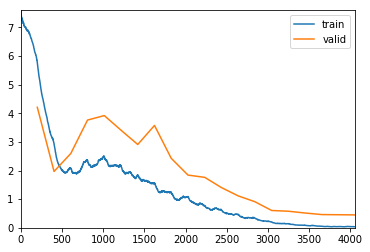

In [19]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [20]:
learn.save("b3_squish_20epochs")

In [21]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.4274041, tensor(0.8960)]

# B3, Squish Resize, 40 Epochs

In [22]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [23]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [24]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0363,  0.0117,  0.0180,  ..., -0.0295,  0.0422,  0.0441],
        [-0.0450, -0.0043,  0.0310,  ...,  0.0407, -0.0149, -0.0302],
        [ 0.0105, -0.0050,  0.0245,  ...,  0.0419, -0.0765,  0.0772],
        ...,
        [ 0.0270, -0.0189,  0.0166,  ...,  0.0120, -0.0176,  0.0398],
        [ 0.0177, -0.0475,  0.0036,  ..., -0.0173, -0.0424,  0.0569],
        [-0.0244,  0.0005,  0.0300,  ...,  0.0362, -0.0031,  0.0442]],
       requires_grad=True)


In [25]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Ford Expedition EL SUV 2009,Hyundai Azera Sedan 2012,Jeep Wrangler SUV 2012,GMC Savana Van 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1, 1], gr

epoch,train_loss,valid_loss,accuracy,time
0,6.118712,4.692035,0.075553,01:33
1,4.005506,2.865157,0.334767,01:33
2,2.048677,1.612346,0.596437,01:33
3,1.334235,1.533145,0.617936,01:33
4,1.388307,2.201801,0.504300,01:33
5,1.381472,2.013957,0.520270,01:33
6,1.483254,2.302932,0.460688,01:33
7,1.671657,2.768269,0.450246,01:34
8,1.667935,3.448619,0.312654,01:33
9,1.695793,2.305486,0.481572,01:33


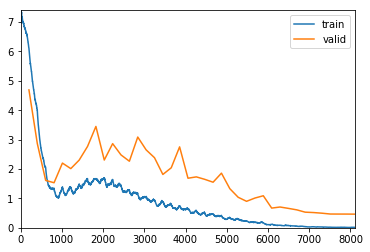

In [26]:
lr = 3e-3
wd = 1e-1
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [27]:
learn.save("b3_squish_40epochs")

In [28]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.42372674, tensor(0.9019)]

# B3, Squish Resize, 60 Epochs

In [29]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [30]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [31]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0520,  0.0558, -0.0087,  ...,  0.0697,  0.0218, -0.0680],
        [ 0.0015,  0.0254, -0.0185,  ..., -0.0654,  0.0353, -0.0520],
        [ 0.0019, -0.0410,  0.0025,  ...,  0.0638, -0.0105, -0.0026],
        ...,
        [-0.0343,  0.0627, -0.0117,  ...,  0.0046, -0.0178,  0.0018],
        [-0.0068, -0.0735,  0.0135,  ..., -0.0398, -0.0231,  0.0026],
        [ 0.0205, -0.0269, -0.0151,  ...,  0.0181,  0.0172, -0.0024]],
       requires_grad=True)


In [32]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi S5 Convertible 2012,Lamborghini Gallardo LP 570-4 Superleggera 2012,Jaguar XK XKR 2012,Bentley Arnage Sedan 2009,Chrysler Aspen SUV 2009
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, k

epoch,train_loss,valid_loss,accuracy,time
0,6.176346,4.710476,0.071867,01:33
1,4.254775,3.030966,0.320025,01:34
2,2.391449,1.793240,0.559582,01:33
3,1.323790,1.255052,0.669533,01:33
4,0.916114,1.268502,0.683047,01:33
5,0.891287,1.419107,0.647420,01:33
6,0.917570,1.670782,0.600123,01:33
7,1.023577,1.712063,0.590909,01:33
8,1.102180,3.099841,0.485872,01:33
9,1.256333,2.476709,0.476044,01:33


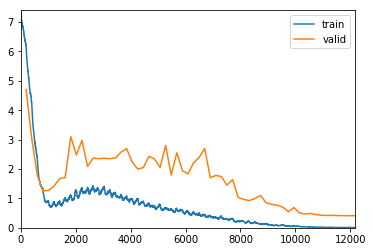

In [33]:
lr = 3e-3
wd = 1e-1
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [34]:
learn.save("b3_squish_60epochs")

In [35]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.44392142, tensor(0.9024)]

# fin